In [118]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [250]:
import pandas as pd
import numpy as np

df = pd.read_hdf('/users/tom/desktop/nsls2/tes/tes_stats.h5')
df = df.loc[~df.isna().any(axis=1)]
df

X  = 2 * df.loc[:, ['a', 'b', 'c', 'd']].values[:, 2:] - 1
X  = X[:13**X.shape[1]]

n_samples, n_dof = X.shape
#X  = np.c_[X, np.linspace(0, 1, len(X))]

y  = np.log(df.wx.values * df.wy.values)[:len(X)]
y  = (y - np.nanmean(y)) / np.nanstd(y)



initial_subset = np.sort(np.random.choice(len(X), size=3 ** n_dof, replace=False))

initial_x, initial_y = X[initial_subset], y[initial_subset]

#train_x, train_y = torch.as_tensor(init_x).float(), torch.as_tensor(init_y).float()

#init_y[-40:] = np.nan

X.shape, y.shape

((169, 2), (169,))

In [352]:
hard_bounds = np.array([[-1,-1,-1,-1],[+1,+1,+1,+1]])[:, :n_dof]
hard_bounds

array([[-1, -1],
       [ 1,  1]])

In [386]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

train_x, train_y = torch.as_tensor(initial_x).float(), torch.as_tensor(initial_y).float()

test_dims = [np.linspace(-1, 1, 5) for d in range(n_dof)]
test_x = torch.cat([torch.Tensor(_).view(-1,1) for _ in np.meshgrid(*test_dims)],dim=1)


In [390]:
from gpytorch.constraints import Positive, Interval

class PolyKernel(gpytorch.kernels.Kernel):
    
    # this kernel is stationary
    is_stationary = True
    
    # We will register the parameter when initializing the kernel
    def __init__(self, dims_to_couple, **kwargs):
        super().__init__(**kwargs)
        
        self.dims_to_couple = torch.as_tensor(np.atleast_2d(dims_to_couple))
        
        # register the raw parameters
        self.register_parameter(name='raw_lengths', parameter=torch.nn.Parameter(torch.ones(n_dof, 1)))
        self.register_parameter(name='raw_couplings', parameter=torch.nn.Parameter(torch.ones(len(self.dims_to_couple), 1)))

        # register the constraints
        self.register_constraint("raw_lengths", Positive())
        self.register_constraint("raw_couplings", Interval(-2, 2))
        print(self.dims_to_couple.shape)
        
    # now set up the 'actual' paramter
    @property
    def lengths(self):
        return self.raw_lengths_constraint.transform(self.raw_lengths)
    
    @property
    def couplings(self):
        return self.raw_couplings_constraint.transform(self.raw_couplings)
    
    @lengths.setter
    def lengths(self, value):
        return self._set_lengths(value)
    def _set_lengths(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_lengths)
        self.initialize(raw_lengths=self.raw_lengths_constraint.inverse_transform(value))
        
    @couplings.setter
    def couplings(self, value):
        return self._set_couplings(value)
    def _set_couplings(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_couplings)
        self.initialize(raw_couplings=self.raw_couplings_constraint.inverse_transform(value))
        
    # this is the kernel function
    def forward(self, x1, x2, **params):
        
        dx = (torch.swapaxes(x1,0,-1)[:,:,None] - torch.swapaxes(x2,0,-1)[:,None,:])
                
        eff_dx = dx / self.lengths[:,0][:,None,None]
        
        px = torch.square(eff_dx).sum(axis=0)
        
        #print(self.dims_to_couple, self.couplings)
        
        for (dim1, dim2), coupling in zip(self.dims_to_couple, self.couplings):
            
            px += coupling * eff_dx[dim1] * eff_dx[dim2]
                    
        return torch.exp(-torch.abs(px)) #+ torch.square(self.white_noise) * (px == 0)
    
PolyKernel(dims_to_couple=((0,1)))

torch.Size([1, 2])


PolyKernel(
  (raw_lengths_constraint): Positive()
  (raw_couplings_constraint): Interval(-2.000E+00, 2.000E+00)
)

In [391]:
class GaussianProcessRegressor(gpytorch.models.ExactGP):
    
    def __init__(self, x, y, likelihood):
        super().__init__(x, y, likelihood)
        
        dims_to_couple = ((0,1),(2,3)) if n_dof == 4 else ((0,1))
        
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = ScaleKernel(MaternKernel())
        self.covar_module = PolyKernel(dims_to_couple=dims_to_couple)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(self.mean_module(x), self.covar_module(x))

class BeamModel():
    
    def __init__(self, init_x, init_y, init_training_iter=1000, **kwargs):
        
        self.torch_inputs  = torch.as_tensor(init_x).float() # always a 32-bit torch tensor
        self.torch_targets = torch.as_tensor(init_y).float()
        
        self.regressor_likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.train(training_iter=init_training_iter)
        
    def train(self, training_iter, hypers=None):
        
        self.regressor = GaussianProcessRegressor(self.torch_inputs, self.torch_targets, self.regressor_likelihood)
        
        if not hypers is None: self.regressor.initialize(**hypers)
    
        self.regressor_likelihood.train()
        self.regressor.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.regressor.parameters(), lr=0.5)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.regressor_likelihood, self.regressor)

        for i in range(training_iter):
            optimizer.zero_grad()
            output = self.regressor(self.torch_inputs)
            loss = - mll(output, self.torch_targets)
            loss.backward()
            optimizer.step()
            
            if (i + 1) % 100 == 0:
                print(f'iter {i + 1}',
                      f'lengths: {self.regressor.covar_module.lengths.detach().numpy().ravel().round(3)}',
                      f'couplings: {self.regressor.covar_module.couplings.detach().numpy().ravel().round(3)}'
                     )
            
    def update(self, x, y):
        
        self.torch_inputs  = torch.cat((self.torch_inputs, torch.as_tensor(x).float()))
        self.torch_targets = torch.cat((self.torch_targets, torch.as_tensor(y).float()))
        
        hypers = {
                    'covar_module.lengths' : bm.regressor.covar_module.lengths,
                  'covar_module.couplings' : bm.regressor.covar_module.couplings
                 }
        
        self.train(training_iter=300, hypers=hypers)
        
    def predict(self, x):
        
        x = torch.as_tensor(np.atleast_2d(x)).float()
        
        # set to evaluation mode
        self.regressor_likelihood.eval()
        self.regressor.eval()
        
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            # Test points are regularly spaced along [0,1]
            prediction = self.regressor_likelihood(self.regressor(x))
            
        return prediction
    

    def mean(self, x):
                
        return self.predict(x).mean.detach().numpy()
    
    def sigma(self, x):
        
        return self.predict(x).stddev.detach().numpy()
    
    def confidence_bound(self, x, z):
        
        prediction = self.predict(x)
        
        return (prediction.mean + z * prediction.stddev).detach().numpy()
        
    @property
    def x(self): return self.torch_inputs.detach().numpy().astype(float)
    
    @property
    def y(self): return self.torch_targets.detach().numpy().astype(float)



bm = BeamModel(initial_x, initial_y)

test_pred = bm.predict(test_x)

torch.Size([1, 2])
iter 100 lengths: [0.66  0.556] couplings: [-1.999]
iter 200 lengths: [0.649 0.556] couplings: [-1.998]
iter 300 lengths: [0.618 0.546] couplings: [-1.999]
iter 400 lengths: [0.662 0.556] couplings: [-1.999]
iter 500 lengths: [0.661 0.556] couplings: [-1.999]
iter 600 lengths: [0.671 0.552] couplings: [-1.999]
iter 700 lengths: [0.465 1.011] couplings: [-1.849]
iter 800 lengths: [0.455 0.971] couplings: [-1.852]
iter 900 lengths: [0.455 0.972] couplings: [-1.852]
iter 1000 lengths: [0.455 0.972] couplings: [-1.852]


In [392]:
%time bm.confidence_bound(test_x[[0]], 1)

CPU times: user 1.43 ms, sys: 1.18 ms, total: 2.62 ms
Wall time: 1.41 ms


array([0.6046959], dtype=float32)

In [393]:
bm.regressor.covar_module.couplings

tensor([[-1.8517]], grad_fn=<AddBackward0>)

In [394]:
hard_bounds.T

array([[-1,  1],
       [-1,  1]])

In [401]:
x0

array([0.5, 1. ], dtype=float32)

In [407]:
import scipy as sp

z = -4

x0 = test_x[bm.confidence_bound(test_x, z).argmin()].detach().numpy()

opt_res = sp.optimize.minimize(bm.confidence_bound, x0=x0, args=(z,), bounds=hard_bounds.T, method='SLSQP')
opt_res

     fun: -3.6424903869628906
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([-0.5, -1. ])

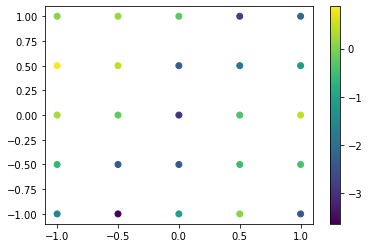

In [408]:
plt.scatter(*test_x.T, c=bm.confidence_bound(test_x, z))
plt.colorbar()

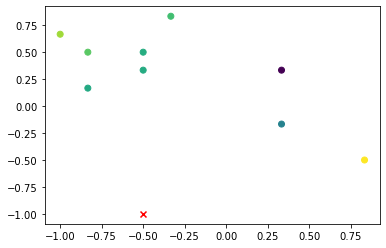

In [409]:
plt.scatter(*bm.x.T, c=bm.y)
plt.scatter(*opt_res.x, marker='x', color='r')

In [ ]:
bm.get_confidence_bound(test_x[[0]], 1)

In [305]:
test_pred = bm.predict(X.mean(axis=0)[None])

tensor([[2.1697e-02, 4.6228e-06]])


In [269]:
sample_subset = np.sort(np.random.choice(len(X), size=1, replace=False))
sample_x, sample_y = X[sample_subset], y[sample_subset]
bm.update(sample_x, sample_y)

torch.Size([1, 2])
iter 100 lengths: [0.682 0.565] couplings: [-1.999]
iter 200 lengths: [0.684 0.567] couplings: [-1.999]
iter 300 lengths: [0.684 0.567] couplings: [-1.999]


In [270]:
bm.regressor.covar_module.lengths

tensor([[0.6844],
        [0.5670]], grad_fn=<SoftplusBackward0>)

In [ ]:
sp.optimize.minimize()

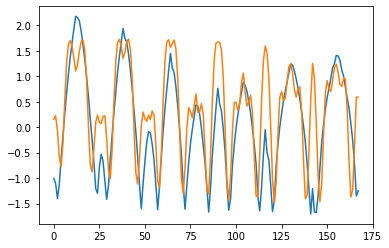

In [271]:
i0, i1 = 0, -1

plt.plot(y[i0:i1])
plt.plot(test_pred.mean.detach().numpy()[i0:i1])


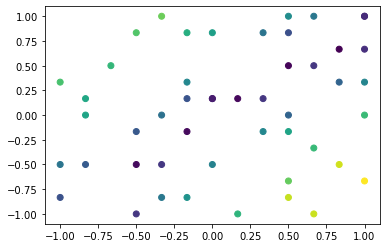

In [204]:
plt.scatter(*bm.x.T, c=bm.y)

In [ ]:
bm.get_confidence_bound(test_x, 1)

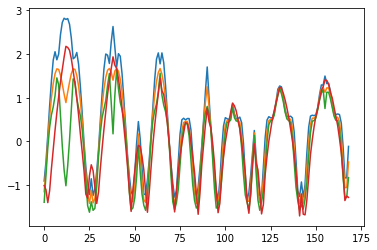

In [278]:
plt.plot(bm.get_confidence_bound(X, 2))
plt.plot(bm.get_confidence_bound(X, 0))
plt.plot(bm.get_confidence_bound(X, -2))

plt.plot(y)

In [331]:
for i in range(0):

    break
    sample_subset = np.sort(np.random.choice(169, size=4, replace=False))
    sample_x, sample_y = X[sample_subset], y[sample_subset]
    bm.update(sample_x, sample_y)
    plt.figure()
    plt.scatter(*test_x.T, c=np.log(bm.predict(test_x).stddev.detach().numpy()))
    plt.colorbar()

In [194]:
sample_x, sample_y

(array([[ 0.33337054, -0.66662946],
        [ 0.16662946,  0.        ],
        [ 0.        ,  0.33337054],
        [ 0.16662946,  0.5       ]]),
 array([-0.6169185 , -2.20815684, -1.30529897, -1.58671474]))

In [ ]:
bm.update(x, y)

In [154]:
bm.regressor.covar_module.length

tensor([[1.1302],
        [0.7655]], grad_fn=<SoftplusBackward0>)

In [155]:
bm.regressor.covar_module.couplings

tensor([[-1.1614]], grad_fn=<AddBackward0>)

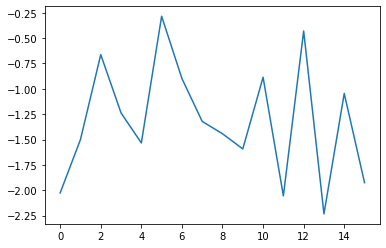

In [156]:
plt.plot(initial_y)

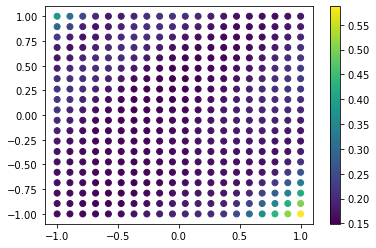

In [145]:
plt.scatter(*test_x.T, c=test_pred.stddev.detach().numpy())
plt.colorbar()

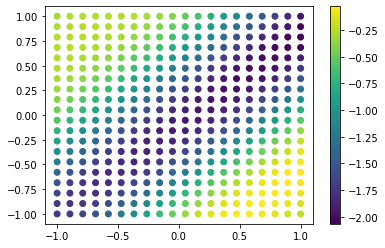

In [146]:
plt.scatter(*test_x.T, c=test_pred.mean.detach().numpy())
plt.colorbar()

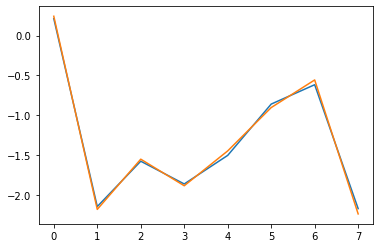

In [332]:
plt.plot(observed_pred.mean.detach().numpy())
plt.plot(train_y.detach().numpy())